 ## Fig 5. ITD STVR 
 ### Set up and load data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load data and reorganize
DF = pd.read_csv('STVR_data.csv')
DF['is_sig'] = DF.pval<0.01
DF = DF[['group', 'animal', 'SGN', 'unit', 'deaf_dur', 'pps', 'stvr', 'pval', 'is_sig']]
DF

,group,animal,SGN,unit,deaf_dur,pps,stvr,pval,is_sig
0,ED-US,I1,14143.5,I1_s01-3,216,20,0.220906,2.827548e-01,False
1,ED-US,I1,14143.5,I1_s01-3,216,40,0.152746,7.551478e-01,False
2,ED-US,I1,14143.5,I1_s01-3,216,80,0.410322,2.100000e-13,True
3,ED-US,I1,14143.5,I1_s01-3,216,160,0.187449,5.065749e-01,False
4,ED-US,I1,14143.5,I1_s01-3,216,320,0.149873,7.734377e-01,False
...,...,...,...,...,...,...,...,...,...
1300,AD,B07,NaN,B07_s46-1,304,40,0.210615,6.321790e-04,True
1301,AD,B07,NaN,B07_s46-1,304,80,0.238427,6.090000e-05,True
1302,AD,B07,NaN,B07_s46-1,304,160,0.248809,2.390000e-05,True
1303,AD,B07,NaN,B07_s46-1,304,320,0.314556,3.120000e-08,True


### Plot Fraction of ITD-sensitive neurons as a function of pulse rate & ITD STVR vs PPS

Text(0, 0.5, 'ITD STVR')

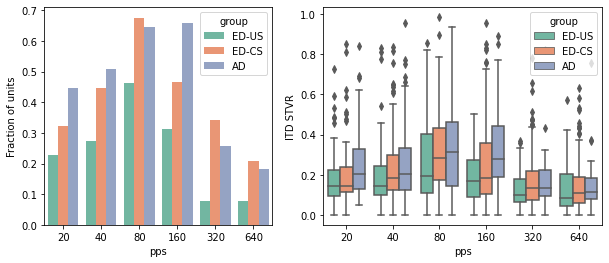

In [4]:
f, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[4.5, 5.5]))
sns.barplot(x='pps', y='is_sig', hue='group', hue_order=['ED-US', 'ED-CS', 'AD'],
            ci=None, data=DF, palette='Set2', ax=axs[0])
axs[0].set_ylabel("Fraction of units")
sns.boxplot(x='pps', y='stvr', hue='group', data=DF, palette='Set2', ax=axs[1])
axs[1].set_ylabel("ITD STVR")

### Two-way ANOVA on arcsine-transformed fraction of ITD sensitive units

In [3]:
DFgrp = DF.groupby(['group', 'pps']).mean()
DFgrp.drop(columns=['stvr', 'pval', 'SGN', 'deaf_dur'], inplace=True)
DFgrp['frac_tr'] = np.arcsin(np.sqrt(DFgrp.is_sig))
DFgrp.reset_index(inplace=True)

model = ols('frac_tr ~ C(group) + C(pps)', data=DFgrp).fit()
tbl = sm.stats.anova_lm(model, typ=2)
tbl['mean_sq'] = tbl.sum_sq/tbl.df
tbl = tbl[['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)']]

print("Two-way ANOVA")
print(tbl)

Two-way ANOVA
            sum_sq    df   mean_sq          F    PR(>F)
C(group)  0.196073   2.0  0.098036  25.488965  0.000119
C(pps)    0.482334   5.0  0.096467  25.080872  0.000023
Residual  0.038462  10.0  0.003846        NaN       NaN


### Two-way ANOVA on arcsine-transformed ITD STVR
Compute effect size ${\omega _{p}}^{2}$ as following:

$${\omega _{p}}^{2}=\frac{df_\text{effect}\times \left ( MS_\text{effect}-MS_\text{error} \right )}{df_\text{effect}\times MS_\text{effect}+\left ( N-df_\text{effect} \right )\times MS_\text{error}}$$

In [4]:
# Partial omega squared
def partial_omega_sq(tbl, ind):
    """Compute partial omega squared as shown. ANOVA table must include mean_sq."""
    part_omega = tbl.df[ind]*(tbl.mean_sq[ind]-tbl.mean_sq['Residual'])/\
             (tbl.sum_sq[ind] + (sum(tbl.df) + 1 - tbl.df[ind])*tbl.mean_sq['Residual'])
    return part_omega

# Set types for anova
DF.group = DF['group'].astype('category')
DF.pps = DF['pps'].astype('category')
DF.stvr = DF['stvr'].astype('float')

# Arcsine transform to make the data more Gaussian-like
DF['stvr_tr'] = np.arcsin(np.sqrt(DF.stvr))

# 2-way anova with interaction
model = ols('stvr_tr ~ C(group, Sum) * C(pps, Sum)', data=DF).fit()
tbl = sm.stats.anova_lm(model, typ=3)
tbl['mean_sq'] = tbl.sum_sq/tbl.df
tbl = tbl[['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)']]
tbl = tbl.drop(index='Intercept')
print('Two-way ANOVA with interaction')
print(tbl)

# Compute effect size
ef_group = partial_omega_sq(tbl, 0)
print("\nPartial omega squared for group: %0.5f" % ef_group)

ef_pps = partial_omega_sq(tbl, 1)
print("Partial omega squared for pps: %0.5f" % ef_pps)

Two-way ANOVA with interaction
                              sum_sq      df   mean_sq          F  \
C(group, Sum)               1.503131     2.0  0.751566  14.265143   
C(pps, Sum)                 5.458994     5.0  1.091799  20.722963   
C(group, Sum):C(pps, Sum)   0.317146    10.0  0.031715   0.601962   
Residual                   67.806187  1287.0  0.052685        NaN   

                                 PR(>F)  
C(group, Sum)              7.454139e-07  
C(pps, Sum)                5.908151e-20  
C(group, Sum):C(pps, Sum)  8.132235e-01  
Residual                            NaN  

Partial omega squared for group: 0.01992
Partial omega squared for pps: 0.07026


### Two-way ANOVA on arcsine-transformed ITD STVR - without interaction

In [5]:
# Interaciton is not significant - try removing it for EF calculation
model = ols('stvr_tr ~ C(group) + C(pps)', data=DF).fit()
tbl = sm.stats.anova_lm(model, typ=2)
tbl['mean_sq'] = tbl.sum_sq/tbl.df
tbl = tbl[['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)']]
print("Two-way ANOVA no interaction")
print(tbl)

# Compute effect size
ef_group = partial_omega_sq(tbl, 0)
print("\nPartial omega squared for group: %0.5f" % ef_group)

ef_pps = partial_omega_sq(tbl, 1)
print("Partial omega squared for pps: %0.5f" % ef_pps)

Two-way ANOVA no interaction
             sum_sq      df   mean_sq          F        PR(>F)
C(group)   1.644541     2.0  0.822270  15.655204  1.913374e-07
C(pps)     6.344610     5.0  1.268922  24.159003  2.643114e-23
Residual  68.123333  1297.0  0.052524        NaN           NaN

Partial omega squared for group: 0.02197
Partial omega squared for pps: 0.08150
